# **Analisis Exploratorio de Datos**


Los objetivos del presente proyecto de analisis de datos son:

1. Comprender el comportamiento general del precio del sistema interconectado nacional.
2. Determinar la correlacion del precio con las otras variables del sistema de generación eléctrica.
3. Comprender la influencia de los fenomenos climáticos en el precio del SIN.
4. Encontrar la influencia del consumo de combustible en el precio de la eléctricidad.

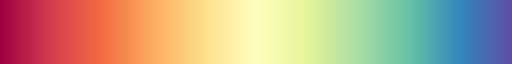

In [32]:
import pandas as pd
import os
import pandas as pd
from sqlalchemy import create_engine
import dotenv

import seaborn as sns
import matplotlib.pylab as plt
sns.set_theme('notebook')
sns.color_palette("Spectral", as_cmap=True)

## Conexión a la Base de Datos de Analítica en AWS

In [33]:
dotenv.load_dotenv("vars.env", override=True)

db_user = os.getenv('DB_USER_AWS')
db_password = os.getenv('DB_PASSWORD_AWS')
db_host = os.getenv('DB_HOST_AWS')
db_port = os.getenv('DB_PORT_AWS')
db_name = os.getenv('DB_NAME_AWS')

conn = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}', echo=False)

## Lectura del DataSet de Analítica

In [34]:
sql_query = """SELECT * FROM analitica_sistema_electrico_colombia"""
df_sistema_electrico = pd.read_sql_query(sql_query, con=conn)
df_sistema_electrico['Date'] = pd.to_datetime(df_sistema_electrico['Date'])
df_sistema_electrico

,Date,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily
0,2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,0.00000,45616100,75130000,15428396811,1.133616e+08,4536.91,21849.64,120.501228,356.70894,7.278816e+05
1,2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,0.00000,43097100,75130000,15428396811,1.254718e+08,12551.38,17079.39,118.495340,355.06286,7.439290e+05
2,2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,0.00000,43400400,75130000,15428396811,1.211452e+08,9118.35,17032.69,121.160145,355.07299,7.490638e+05
3,2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,0.00000,40410400,75130000,15428396811,1.439317e+08,1513370.10,7174.60,123.962937,355.07299,7.727362e+05
4,2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,0.00000,41190600,75130000,15428396811,1.498691e+08,3057651.95,0.00,120.666437,354.78317,7.674916e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08,0.00,0.00,215.201028,742.65054,1.077649e+06
5230,2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08,0.00,0.00,160.221522,742.65054,9.592092e+05
5231,2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08,12438.22,4315.01,106.818940,742.65054,8.649091e+05
5232,2024-04-29,2.223545e+08,2.223672e+08,2869374.84,5.672510e+09,50743.73833,303206200,222790000,17359561885,2.194978e+08,41646.96,12662.44,136.110230,742.65054,6.467688e+05


## Exploración del Dataset y sus Variables

In [35]:
df_sistema_electrico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5234 entries, 0 to 5233
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     5234 non-null   datetime64[ns]
 1   generacion_sistema_daily                 5234 non-null   float64       
 2   generacion_ideal_sistema_daily           5234 non-null   float64       
 3   perdidas_sistema_daily                   5234 non-null   float64       
 4   volumen_util_energia_sistema_daily       5234 non-null   float64       
 5   emisiones_sistema_daily                  5234 non-null   float64       
 6   aportes_energia_sistema_daily            5234 non-null   int64         
 7   aportes_energia_mediaHist_sistema_daily  5234 non-null   int64         
 8   capacidad_util_energia_sistema_daily     5234 non-null   int64         
 9   demanda_real_sistema_daily               

In [36]:
df_sistema_electrico.describe()

,Date,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily
count,5234,5.234000e+03,5.234000e+03,5.234000e+03,5.234000e+03,5234.000000,5.234000e+03,5.234000e+03,5.234000e+03,5.234000e+03,5.234000e+03,5.234000e+03,5234.000000,5234.000000,5.234000e+03
mean,2017-03-01 12:00:00,1.850621e+08,1.851752e+08,2.800156e+06,1.086632e+10,14180.501519,1.627329e+08,1.674084e+08,1.649445e+10,1.832538e+08,1.731938e+06,9.918166e+05,225.569533,499.731301,3.815048e+05
min,2010-01-01 00:00:00,1.154191e+08,1.154409e+08,-2.118570e+06,4.958518e+09,0.000000,2.903210e+07,6.977000e+07,1.509751e+10,1.133616e+08,0.000000e+00,0.000000e+00,35.356673,289.787340,1.135214e+05
25%,2013-08-01 06:00:00,1.681574e+08,1.682075e+08,2.432048e+06,9.258528e+09,0.000000,1.047243e+08,1.271200e+08,1.542840e+10,1.661841e+08,4.538618e+03,8.651350e+02,106.351090,363.176550,2.491524e+05
50%,2017-03-01 12:00:00,1.842993e+08,1.845294e+08,2.753888e+06,1.108863e+10,0.000000,1.492896e+08,1.772600e+08,1.692088e+10,1.828501e+08,3.960514e+04,1.146763e+04,158.982260,449.830580,3.409360e+05
75%,2020-09-29 18:00:00,1.990774e+08,1.993305e+08,3.118325e+06,1.277719e+10,24442.364002,2.054747e+08,2.066700e+08,1.719771e+10,1.983670e+08,2.418663e+06,3.745736e+05,247.326889,555.401030,4.769475e+05
max,2024-04-30 00:00:00,2.504391e+08,2.504391e+08,7.079952e+06,1.564980e+10,83577.438230,5.912453e+08,2.800400e+08,1.823718e+10,2.469374e+08,3.505239e+07,1.091103e+07,1942.692797,1037.232360,1.104847e+06
std,NaN,2.284277e+07,2.288304e+07,5.686833e+05,2.412986e+09,18506.220919,7.948753e+07,4.962312e+07,9.329839e+08,2.286958e+07,2.978020e+06,2.152138e+06,205.734350,182.292409,1.729107e+05


## Descripción de las Variables

A continuación se lista todas las variables disponibles para el analisis.
El dataset continue el valor de la variable por cada dia de operacion del sistema.

| No. | Variable                                | Metrica                               | Unidad | Descripción                                                                                                    | Unidad de Análisis |
|-----|-----------------------------------------|---------------------------------------|--------|----------------------------------------------------------------------------------------------------------------|---------------------|
| 1   | generacion_sistema_daily                | Generación por Sistema                | kWh    | Generación neta de cada una de las plantas Nacionales en sus puntos de frontera.                               | GWh                 |
| 2   | generacion_ideal_sistema_daily          | Generación Ideal por Sistema          | kWh    | Despacho de generación que resulta de considerar una red de transporte inexistente.                             | GWh                 |
| 3   | perdidas_sistema_daily                  | Pérdidas de Energía por Sistema       | kWh    | Cantidad de las inyecciones de energía al Sistema de Transmisión Nacional, menos la cantidad de los flujos... | GWh                 |
| 4   | volumen_util_energia_sistema_daily     | Volumen Útil diario Energía Sistema  | kWh    | Volumen almacenado por encima del Nivel Mínimo Técnico, reportado diariamente por los agentes.                 | GWh                 |
| 5   | emisiones_sistema_daily                 | Emisiones de CO2 por RecursoComb      | TonCO2 | Emisiones totales de Dióxido de Carbono – CO2 de las plantas de generación registradas ante el CND.            | kTonCO2             |
| 6   | aportes_energia_sistema_daily           | Aportes Energía por Río               | kWh    | Caudales en energía de los ríos que aportan agua a algún embalse del SIN.                                       | GWh                 |
| 7   | aportes_energia_mediaHist_sistema_daily| Aportes Media Histórica Energía por Río| kWh    | Caudal medio mensual histórico en energía para los ríos del SIN.                                                | GWh                 |
| 8   | capacidad_util_energia_sistema_daily   | Capacidad Útil Energía por Embalse    | kWh    | Corresponde al Volumen Útil del Embalse, que se define como el volumen almacenado entre el nivel Mínimo Téc... | GWh                 |
| 9   | demanda_real_sistema_daily             | Demanda Real por sistema              | kWh    | Demanda de usuarios regulados y no regulados que hacen parte del Sistema Interconectado Nacional.               | GWh                 |
| 10  | exportaciones_sistema_daily            | Exportaciones de energía              | kWh    | Transferencias de Energía desde Colombia hacia otros países.                                                    | MWh                 |
| 11  | importaciones_sistema_daily            | Importaciones de energía              | kWh    | Transferencias de Energía desde otros países para abastecer la demanda nacional.                                | MWh                 |
| 12  | precio_bolsa_sistema_daily             | Precio Bolsa Promedio Aritmético      | COP/kWh| Promedio aritmético del precio de bolsa nacional.                                                               | COP/kWh             |
| 13  | precio_escasez_sistema_daily           | Precio Marginal Escasez por Sistema   | COP/kWh| Precio Marginal de Escasez calculado de acuerdo con la Resolución CREG 140 del 2017.                            | COP/kWh             |
| 14  | comsumo_combustible_daily              | Consumo Combustible MBTU por Recurso  | MBTU   | Los generadores térmicos deben reportar diariamente el consumo de combustible en MBTU.                          | MMBTU               |


## Conversion de Unidades a las Unidades de Análisis

In [43]:
def convertir_unidades(df): 
    # Crear un diccionario con los factores de conversión
    conversion_factors = {
        'generacion_sistema_daily': 1e-6,  # kWh to GWh
        'generacion_ideal_sistema_daily': 1e-6,  # kWh to GWh
        'perdidas_sistema_daily': 1e-6,  # kWh to GWh
        'volumen_util_energia_sistema_daily': 1e-6,  # kWh to GWh
        'emisiones_sistema_daily': 1e-3,  # TonCO2 to kTonCO2
        'aportes_energia_sistema_daily': 1e-6,  # kWh to GWh
        'aportes_energia_mediaHist_sistema_daily': 1e-6,  # kWh to GWh
        'capacidad_util_energia_sistema_daily': 1e-6,  # kWh to GWh
        'demanda_real_sistema_daily': 1e-6,  # kWh to GWh
        'exportaciones_sistema_daily': 1e-3,  # kWh to MWh
        'importaciones_sistema_daily': 1e-3,  # kwh to MWh
        'precio_bolsa_sistema_daily': 1,  # COP/kWh to COP/kWh (no conversion needed)
        'precio_escasez_sistema_daily': 1,  # COP/kWh to COP/kWh (no conversion needed)
        'comsumo_combustible_daily': 1e-3  # MBTU to MMBTU
    }

    # Aplicar las conversiones
    for column, factor in conversion_factors.items():
        df[column] = df[column] * factor

    # Mostrar el DataFrame convertido
    return df

In [44]:
df_sistema_electrico_converted = df_sistema_electrico.copy()
df_sistema_electrico_converted = convertir_unidades(df_sistema_electrico_converted)
df_sistema_electrico_converted

,Date,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily
0,2010-01-01,115.419084,115.440934,2.079353,10006.614779,0.000000,45.6161,75.13,15428.396811,113.361581,4.53691,21.84964,120.501228,356.70894,727.881567
1,2010-01-02,127.681195,127.698274,2.226467,9995.146811,0.000000,43.0971,75.13,15428.396811,125.471807,12.55138,17.07939,118.495340,355.06286,743.929011
2,2010-01-03,123.637778,123.654811,2.509638,9992.677303,0.000000,43.4004,75.13,15428.396811,121.145173,9.11835,17.03269,121.160145,355.07299,749.063827
3,2010-01-04,145.957459,144.411382,2.032915,9965.341214,0.000000,40.4104,75.13,15428.396811,143.931719,1513.37010,7.17460,123.962937,355.07299,772.736247
4,2010-01-05,152.148029,149.034819,2.278902,9926.759570,0.000000,41.1906,75.13,15428.396811,149.869128,3057.65195,0.00000,120.666437,354.78317,767.491641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,2024-04-26,224.604764,224.604764,3.468542,5399.083900,81.390038,175.1971,222.79,17359.561885,221.136223,0.00000,0.00000,215.201028,742.65054,1077.648732
5230,2024-04-27,217.165537,217.165537,3.317766,5454.064900,72.221148,190.9257,222.79,17359.561885,213.847772,0.00000,0.00000,160.221522,742.65054,959.209242
5231,2024-04-28,194.188787,194.193102,2.880163,5557.993200,65.899834,206.1877,222.79,17359.561885,191.312939,12.43822,4.31501,106.818940,742.65054,864.909070
5232,2024-04-29,222.354541,222.367204,2.869375,5672.509900,50.743738,303.2062,222.79,17359.561885,219.497829,41.64696,12.66244,136.110230,742.65054,646.768820


## Visualización de las distribuiciones de las variables

In [8]:
def plot_distribution(df, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))

    # Histograma de distribución de CO2
    hist = sns.histplot(data=df, kde=True, bins=10)
    hist.set_xlabel(xlabel)
    hist.set_ylabel(ylabel)
    hist.set_title(title)

    # Boxplot superpuesto
    dist_box = hist.twinx()
    sns.boxplot(x=df, ax=dist_box, color='red', showfliers=False)
    dist_box.set(ylim=(-1, 10))

    plt.show()

In [9]:
for column in df_sistema_electrico.columns:
    if column != "Date":
        plot_distribution(df_sistema_electrico[column], xlabel=, ylabel='Y Label', title=f'Distribución de {column}')

SyntaxError: invalid syntax (4256711665.py, line 3)

In [ ]:
7.278816e+05/10**3

727.8815999999999